<a href="https://colab.research.google.com/github/Viroslav/Projects/blob/main/Cath_me_if_You_can.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

В обучающей выборке содержатся следующие признаки:

- site1 – индекс первого посещенного сайта в сессии
- time1 – время посещения первого сайта в сессии
- ...
- site10 – индекс 10-го посещенного сайта в сессии
- time10 – время посещения 10-го сайта в сессии
- target – целевая переменная, 1 для сессий Элис, 0 для сессий других пользователей

Сессии пользователей выделены таким образом, что они не могут быть длиннее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд либо когда сессия заняла по времени более 30 минут.

В таблице встречаются пропущенные значения, это значит, что сессия состоит менее, чем из 10 сайтов. Заменим пропущенные значения нулями и приведем признаки к целому типу. Также загрузим словарь сайтов и посмотрим, как он выглядит:

In [ ]:
# загрузим обучающую и тестовую выборки
train_df = pd.read_csv("/content/train_sessions.csv", index_col="session_id")
test_df = pd.read_csv("/content/test_sessions.csv", index_col="session_id")

# приведем колонки time1, ..., time10 к временному формату
times = ["time%s" % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# отсортируем данные по времени
train_df = train_df.sort_values(by="time1")

# посмотрим на заголовок обучающей выборки
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [ ]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [ ]:
train_df.dtypes

site1              int64
time1     datetime64[ns]
site2            float64
time2     datetime64[ns]
site3            float64
time3     datetime64[ns]
site4            float64
time4     datetime64[ns]
site5            float64
time5     datetime64[ns]
site6            float64
time6     datetime64[ns]
site7            float64
time7     datetime64[ns]
site8            float64
time8     datetime64[ns]
site9            float64
time9     datetime64[ns]
site10           float64
time10    datetime64[ns]
target             int64
dtype: object

In [ ]:
# приведем колонки site1, ..., site10 к целочисленному формату и заменим пропуски нулями
sites = ["site%s" % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype("int")
test_df[sites] = test_df[sites].fillna(0).astype("int")

# загрузим словарик сайтов
with open(r"/content/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# датафрейм словарика сайтов
sites_dict_df = pd.DataFrame(
    list(site_dict.keys()), index=list(site_dict.values()), columns=["site"]
)
print(u"всего сайтов:", sites_dict_df.shape[0])
sites_dict_df.head()

всего сайтов: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [ ]:
train_df.dtypes

site1              int64
time1     datetime64[ns]
site2              int64
time2     datetime64[ns]
site3              int64
time3     datetime64[ns]
site4              int64
time4     datetime64[ns]
site5              int64
time5     datetime64[ns]
site6              int64
time6     datetime64[ns]
site7              int64
time7     datetime64[ns]
site8              int64
time8     datetime64[ns]
site9              int64
time9     datetime64[ns]
site10             int64
time10    datetime64[ns]
target             int64
dtype: object

In [ ]:
sites = ["site{}".format(i) for i in range(1, 11)]
sites

['site1',
 'site2',
 'site3',
 'site4',
 'site5',
 'site6',
 'site7',
 'site8',
 'site9',
 'site10']

In [ ]:
sites = ["site%s" % i for i in range(1, 11)]
sites

['site1',
 'site2',
 'site3',
 'site4',
 'site5',
 'site6',
 'site7',
 'site8',
 'site9',
 'site10']

Выделим целевую переменную и объединим выборки, чтобы вместе привести их к разреженному формату.

In [ ]:
# наша целевая переменная
y_train = train_df["target"]

# объединенная таблица исходных данных
full_df = pd.concat([train_df.drop("target", axis=1), test_df])

# индекс, по которому будем отделять обучающую выборку от тестовой
idx_split = train_df.shape[0]

In [ ]:
idx_split

253561

In [ ]:
full_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,945,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,946,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,952,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22


Для самой первой модели будем использовать только посещенные сайты в сессии (но не будем обращать внимание на временные признаки). 
<br>За таким выбором данных для модели стоит такая идея: у Элис есть свои излюбленные сайты, и чем чаще вы видим эти сайты в сессии, тем выше вероятность, что это сессия Элис и наоборот.

Подготовим данные, из всей таблицы выберем только признаки site1, site2, ... , site10. Напомним, что пропущенные значения заменены нулем. Вот как выглядят первые строки таблицы:


In [ ]:
# табличка с индексами посещенных сайтов в сессии
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


Сессии представляют собой последовательность индексов сайтов и данные в таком виде неудобны для линейных методов. В соответствии с нашей гипотезой (у Элис есть излюбленные сайты) надо преобразовать эту таблицу таким образом, чтобы каждому возможному сайту соответствовал свой отдельный признак (колонка), а его значение равнялось бы количеству посещений этого сайта в сессии. Это делается в две строчки:

In [ ]:
from scipy.sparse import csr_matrix
csr_matrix?

In [ ]:
# последовательность с индексами
sites_flatten = full_sites.values.flatten()
sites_flatten, sites_flatten.shape

(array([  56,   55,    0, ..., 1098, 1098, 1098]), (3363580,))

In [ ]:
# искомая матрица
full_sites_sparse = csr_matrix(
    (
        [1] * sites_flatten.shape[0],
        sites_flatten,
        range(0, sites_flatten.shape[0] + 10, 10),
    )
)[:, 1:]
full_sites_sparse.shape, full_sites_sparse

((336358, 48371), <336358x48371 sparse matrix of type '<class 'numpy.int64'>'
 	with 3195430 stored elements in Compressed Sparse Row format>)

In [ ]:
X_train_sparse = full_sites_sparse[:idx_split]
X_test_sparse = full_sites_sparse[idx_split:]

In [ ]:
X_train_sparse.shape, y_train.shape

((253561, 48371), (253561,))

Еще один плюс использования разреженных матриц в том, что для них имеются специальные реализации как матричных операций, так и алгоритмов машинного обучения, что подчас позволяет ощутимо ускорить операции за счет особенностей структуры данных. Это касается и логистической регрессии. Вот теперь у нас все готово для построения нашей первой модели.
<br>
<br> Разреженные матрицы - допустим сайт для 2 сессии и список сайтов для неё же 2:[57, 56, 205, ....]

#2. Построение первой модели
##Итак, у нас есть алгоритм и данные для него, построим нашу первую модель, воспользовавшись релизацией логистической регрессии из пакета sklearn с параметрами по умолчанию. Первые 90% данных будем использовать для обучения (обучающая выборка отсортирована по времени), а оставшиеся 10% для проверки качества (validation).

Напишите простую функцию, которая будет возвращать качество модели на отложенной выборке, и обучите наш первый классификатор.

In [ ]:
%%time 
logit = LogisticRegression(n_jobs = -1, random_state = 17)
logit.fit(X_train_sparse, y_train)

CPU times: user 136 ms, sys: 55.7 ms, total: 192 ms
Wall time: 4.75 s


LogisticRegression(n_jobs=-1, random_state=17)

In [ ]:
logit, logit.predict(X_train_sparse[0]) # так получается именно предсказание 0 или 1, чтобы получить именно вероятность,нужно использовать proba

(LogisticRegression(n_jobs=-1, random_state=17), array([0]))

In [ ]:
logit.predict_proba(X_test_sparse[0, :])  # вер-ть класса 0, вер-ть класса - 1

array([[0.99778024, 0.00221976]])

In [ ]:
logit.predict_proba(X_test_sparse[:15, :])[:, 1]  # выберем второй столбец - вер-ть класса - 1

array([2.21976363e-03, 2.51896229e-09, 6.16027591e-09, 1.32268970e-08,
       2.72906695e-05, 1.51180478e-04, 4.42378701e-04, 1.01245078e-04,
       7.77456105e-04, 1.04950780e-01, 2.37984922e-05, 9.55242625e-05,
       2.86739456e-04, 3.58988651e-01, 3.47106166e-05])

In [ ]:
def get_auc_lr_valid(X, y, max_iter = 100, C=1.0, ratio=0.9, seed=17):
    """
    X, y – выборка
    ratio – в каком отношении поделить выборку
    C, seed – коэф-т регуляризации и random_state 
              логистической регрессии
    """
    X_train, X_valid, y_train, y_valid = X[:int(X.shape[0] * ratio), :], \
                                         X[int(X.shape[0] * (1- ratio)):, :], \
                                         y[:int(y.shape[0] * ratio)], \
                                         y[int(y.shape[0] * (1- ratio)):]
                                  
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score
    clf = LogisticRegression(C = C, random_state = seed, verbose = 1, \
                             max_iter = max_iter, n_jobs = -1).fit(X_train, y_train)
    return f"roc_auc_score: {roc_auc_score(y_valid, clf.predict(X_valid))}"

In [ ]:
%%time
get_auc_lr_valid(X_train_sparse, y_train, max_iter = 400)  # не верно работает, так как мы используем сразу классы 0, 1, надо брать вер-ти классов

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


CPU times: user 188 ms, sys: 29.9 ms, total: 217 ms
Wall time: 9.3 s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished


'roc_auc_score: 0.6217343469590473'

In [ ]:
def get_auc_lr_valid_proba(X, y, max_iter = 100, C=1.0, ratio=0.9, seed=17):
    """
    X, y – выборка
    ratio – в каком отношении поделить выборку
    C, seed – коэф-т регуляризации и random_state 
              логистической регрессии
    """
    X_train, X_valid, y_train, y_valid = X[:int(X.shape[0] * ratio), :], \
                                         X[int(X.shape[0] * (1- ratio)):, :], \
                                         y[:int(y.shape[0] * ratio)], \
                                         y[int(y.shape[0] * (1- ratio)):]
                                  
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score
    clf = LogisticRegression(C = C, random_state = seed, verbose = 1, \
                             max_iter = max_iter, n_jobs = -1).fit(X_train, y_train)
    return f"roc_auc_score: {roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1])}"

In [ ]:
%%time
get_auc_lr_valid_proba(X_train_sparse, y_train, max_iter = 100)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished


CPU times: user 189 ms, sys: 19.1 ms, total: 208 ms
Wall time: 4.09 s


'roc_auc_score: 0.9695370508853196'

Будем считать эту модель нашей первой отправной точкой (baseline). Для построения модели для прогноза на тестовой выборке необходимо обучить модель заново уже на всей обучающей выборке (пока наша модель обучалась лишь на части данных), что повысит ее обобщающую способность:

In [ ]:
# функция для записи прогнозов в файл
def write_to_submission_file(
    predicted_labels, out_file, target="target", index_label="session_id"
):
    predicted_df = pd.DataFrame(
        predicted_labels,
        index=np.arange(1, predicted_labels.shape[0] + 1),
        columns=[target],
    )
    predicted_df.to_csv(out_file, index_label=index_label)

Обучите модель на всей выборке, сделайте прогноз для тестовой выборки и сделайте посылку в соревновании.

In [ ]:
%%time 
logit = LogisticRegression(n_jobs = -1, random_state = 17, max_iter = 300)
logit.fit(X_train_sparse, y_train)

CPU times: user 97.7 ms, sys: 22.6 ms, total: 120 ms
Wall time: 10.1 s


LogisticRegression(max_iter=300, n_jobs=-1, random_state=17)

In [ ]:
%%time
test_pred = logit.predict_proba(X_test_sparse)[:, 1]
test_pred

CPU times: user 9.48 ms, sys: 1.06 ms, total: 10.5 ms
Wall time: 10.5 ms


array([2.06724754e-03, 4.31148330e-09, 1.85794103e-08, ...,
       8.49272853e-03, 4.05954280e-04, 1.88037424e-05])

In [ ]:
write_to_submission_file(test_pred, '/content/submission.csv')

In [ ]:
pd.Series(test_pred, index = range(1, test_pred.shape[0] +1), name='target') \
    .to_csv('/content/submission.csv', header=True, index_label ='session_id')  # можно ещё так)

In [ ]:
!head submission.csv

session_id,target
1,0.0020672475403929803
2,4.311483300769458e-09
3,1.8579410321570902e-08
4,2.10533554297997e-08
5,3.013301076658296e-05
6,0.00018010607878885242
7,0.00042410463740370725
8,0.0001112528534025052
9,0.0007223311750303574


#3. Улучшение модели, построение новых признаков
##Создайте такой признак, который будет представлять собой число вида ГГГГММ от той даты, когда проходила сессия, например 201407 -- 2014 год и 7 месяц. Таким образом, мы будем учитывать помесячный линейный тренд за весь период предоставленных данных.

In [ ]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0


In [ ]:
times = ["time{}".format(i) for i in range(1,11)]
times

['time1',
 'time2',
 'time3',
 'time4',
 'time5',
 'time6',
 'time7',
 'time8',
 'time9',
 'time10']

In [ ]:
train_df[times].head()

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
54843,2013-01-12 08:37:23,2013-01-12 08:37:23,2013-01-12 09:07:07,2013-01-12 09:07:09,NaT,NaT,NaT,NaT,NaT,NaT
77292,2013-01-12 08:50:13,2013-01-12 08:50:14,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17
114021,2013-01-12 08:50:17,2013-01-12 08:50:17,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:20
146670,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:22,2013-01-12 08:50:22,2013-01-12 08:50:22


In [ ]:
train_df['time1'].head()

session_id
21669    2013-01-12 08:05:57
54843    2013-01-12 08:37:23
77292    2013-01-12 08:50:13
114021   2013-01-12 08:50:17
146670   2013-01-12 08:50:20
Name: time1, dtype: datetime64[ns]

In [ ]:
train_df['time1'].tail()

session_id
12224    2014-04-30 23:33:48
164438   2014-04-30 23:34:15
12221    2014-04-30 23:38:08
156968   2014-04-30 23:38:36
204762   2014-04-30 23:39:53
Name: time1, dtype: datetime64[ns]

In [ ]:
train_df['time1'].apply(lambda ts: 100 * ts.year + ts.month).head()

session_id
21669     201301
54843     201301
77292     201301
114021    201301
146670    201301
Name: time1, dtype: int64

In [ ]:
new_feat_train = pd.DataFrame(index=train_df.index)
new_feat_test = pd.DataFrame(index=test_df.index)

In [ ]:
new_feat_train.tail()

""
session_id
12224
164438
12221
156968
204762


In [ ]:
new_feat_train['year_month'] = train_df['time1'].apply(lambda ts: int(100 * ts.year + ts.month))
new_feat_test['year_month'] = test_df['time1'].apply(lambda ts: int(100 * ts.year + ts.month))

In [ ]:
new_feat_train.tail()

,year_month
session_id,
12224,201404
164438,201404
12221,201404
156968,201404
204762,201404


In [ ]:
scaler = StandardScaler()
scaler.fit(new_feat_train['year_month'].values.reshape(-1,1))
new_feat_train['year_month_scaled'] = scaler.transform(new_feat_train['year_month'].values.reshape(-1,1))
new_feat_test['year_month_scaled'] = scaler.transform(new_feat_test['year_month'].values.reshape(-1,1))

In [ ]:
new_feat_train.head()

,year_month,year_month_scaled
session_id,,
21669,201301,-1.744405
54843,201301,-1.744405
77292,201301,-1.744405
114021,201301,-1.744405
146670,201301,-1.744405


Добавьте новый признак, предварительно отмасштабировав его с помощью StandardScaler, и снова посчитайте ROC AUC на отложенной выборке.

In [ ]:
X_train_sparse.shape, new_feat_train['year_month_scaled'].values.shape

((253561, 48371), (253561,))

In [ ]:
X_train_sparse.shape, new_feat_train['year_month_scaled'].values.reshape(-1, 1).shape 
# НУЖНО ПРЕДСТАВИТЬ ДЛЯ HSTACK в виде столбца, для этого reshape

((253561, 48371), (253561, 1))

In [ ]:
X_train_sparse_new = hstack([X_train_sparse, new_feat_train['year_month_scaled'].values.reshape(-1, 1)])
# так как у нас X_train_sparse - разреженная матрица, нужно объединять его с 
# помощью hstack --- по горизонтали их объединит
X_test_sparse_new = hstack([X_test_sparse, new_feat_test['year_month_scaled'].values.reshape(-1, 1)])

In [ ]:
X_train_sparse_new.shape # размерность выросла на 1 48371->48372

(253561, 48372)

In [ ]:
%%time
get_auc_lr_valid_proba(X_train_sparse_new, y_train)

TypeError: ignored

необходимо ещё раз явно преобразовать к типу csr_matrix

In [ ]:
X_train_sparse_new = csr_matrix(hstack([X_train_sparse, new_feat_train['year_month_scaled'].values.reshape(-1, 1)]))
X_test_sparse_new = csr_matrix(hstack([X_test_sparse, new_feat_test['year_month_scaled'].values.reshape(-1, 1)]))

In [ ]:
X_train_sparse_new.shape

(253561, 48372)

In [ ]:
%%time
get_auc_lr_valid_proba(X_train_sparse_new, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished


CPU times: user 188 ms, sys: 26.6 ms, total: 215 ms
Wall time: 4.02 s


'roc_auc_score: 0.9698391950477326'

**Добавьте два новых признака: start_hour и morning.**

Признак start_hour – это час в который началась сессия (от 0 до 23), а бинарный признак morning равен 1, если сессия началась утром и 0, если сессия началась позже (будем считать, что утро это если start_hour равен 11 или меньше).
<br>

**Посчитйте ROC AUC на отложенной выборке для выборки с:**
<br>-сайтами, start_month и start_hour
<br>-сайтами, start_month и morning
<br>-сайтами, start_month, start_hour и morning

In [ ]:
new_feat_train = pd.DataFrame()
new_feat_train['start_hour'] = train_df['time1'].apply(lambda ts: ts.hour)
new_feat_test = pd.DataFrame()
new_feat_test['start_hour'] = test_df['time1'].apply(lambda ts: ts.hour)

In [ ]:
new_feat_train.head()

,start_hour
session_id,
21669,8
54843,8
77292,8
114021,8
146670,8


In [ ]:
new_feat_train['morning'] = pd.Series([i for i in range(len(new_feat_train)+1)])
new_feat_test['morning'] = pd.Series([i for i in range(len(new_feat_test)+1)])

In [ ]:
new_feat_train['morning'] = new_feat_train['start_hour'].apply(lambda x : 1 if (x <= 11) else 0)
new_feat_test['morning'] = new_feat_test['start_hour'].apply(lambda x : 1 if (x <= 11) else 0)

In [ ]:
new_feat_train.head()

,start_hour,morning
session_id,,
21669,8,1
54843,8,1
77292,8,1
114021,8,1
146670,8,1


In [ ]:
scaler = StandardScaler()
scaler.fit(new_feat_train['start_hour'].values.reshape(-1,1))
new_feat_train['start_hour'] = scaler.transform(new_feat_train['start_hour'].values.reshape(-1,1))
new_feat_test['start_hour'] = scaler.transform(new_feat_test['start_hour'].values.reshape(-1,1))

In [ ]:
scaler = StandardScaler()
scaler.fit(new_feat_train['morning'].values.reshape(-1,1))
new_feat_train['morning'] = scaler.transform(new_feat_train['morning'].values.reshape(-1,1))
new_feat_test['morning'] = scaler.transform(new_feat_test['morning'].values.reshape(-1,1))

In [ ]:
new_feat_train.head()

,start_hour,morning
session_id,,
21669,-1.357366,1.039061
54843,-1.357366,1.039061
77292,-1.357366,1.039061
114021,-1.357366,1.039061
146670,-1.357366,1.039061


In [ ]:
new_feat_train.head(), new_feat_test.head()

(            start_hour   morning
 session_id                      
 21669        -1.357366  1.039061
 54843        -1.357366  1.039061
 77292        -1.357366  1.039061
 114021       -1.357366  1.039061
 146670       -1.357366  1.039061,             start_hour   morning
 session_id                      
 1            -0.407823  1.039061
 2            -0.407823  1.039061
 3             0.858234 -0.962408
 4            -0.724338  1.039061
 5             0.858234 -0.962408)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


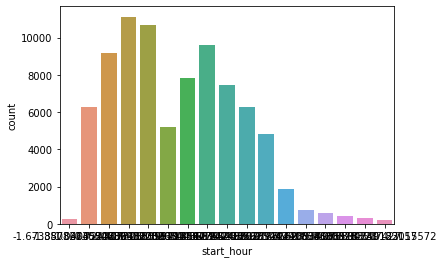

In [ ]:
#sns.countplot(new_feat_train.start_hour);
sns.countplot(new_feat_test.start_hour);

In [ ]:
new_feat_test.head()

,start_hour,morning
session_id,,
1,-0.407823,1.039061
2,-0.407823,1.039061
3,0.858234,-0.962408
4,-0.724338,1.039061
5,0.858234,-0.962408


In [ ]:
pd.concat([new_feat_train, y_train], axis = 1).query('target == 1')

,start_hour,morning,target
session_id,,,
251175,1.174749,-0.962408,1
196388,1.174749,-0.962408,1
172448,1.174749,-0.962408,1
70129,1.174749,-0.962408,1
206254,1.174749,-0.962408,1
...,...,...,...
188473,1.491263,-0.962408,1
40139,1.491263,-0.962408,1
205622,1.491263,-0.962408,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


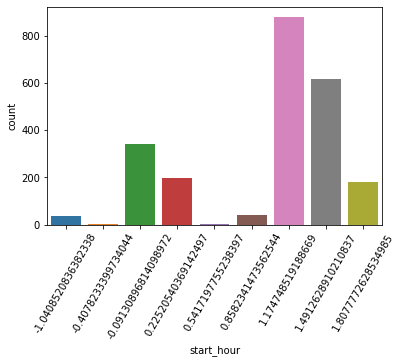

In [ ]:
sns.countplot(pd.concat([new_feat_train, y_train], axis = 1).query('target == 1').start_hour);
plt.xticks(rotation=60);

Можно заметить, что ALice соответсвуют определённые часы старта сессий, попробуем добавить эту фичу

In [ ]:
X_train_sparse_new_1 = csr_matrix(hstack([X_train_sparse_new, \
                      new_feat_train['start_hour'].values.reshape(-1, 1)]))

In [ ]:
new_feat_train.start_hour.value_counts(), new_feat_test.start_hour.value_counts()

(-0.724338    33676
 -1.040852    31741
 -0.407823    30798
  0.541720    27306
 -1.357366    25369
  0.225205    22552
  0.858234    21640
  1.174749    18739
 -0.091309    17420
  1.491263    12830
  1.807777     3898
  2.757320     1705
  2.124292     1540
  3.073835     1467
  3.390349     1339
  2.440806     1200
 -1.673881      341
 Name: start_hour, dtype: int64, -0.724338    11114
 -0.407823    10677
  0.541720     9597
 -1.040852     9170
  0.225205     7840
  0.858234     7436
 -1.357366     6297
  1.174749     6263
 -0.091309     5187
  1.491263     4808
  1.807777     1891
  2.124292      767
  2.440806      593
  2.757320      424
  3.073835      290
 -1.673881      259
  3.390349      184
 Name: start_hour, dtype: int64)

In [ ]:
X_train_sparse_new_1 = csr_matrix(hstack([X_train_sparse_new, \
                      new_feat_train['start_hour'].values.reshape(-1, 1)]))

In [ ]:
X_train_sparse_new_1.shape, y_train.shape

((253561, 48373), (253561,))

In [ ]:
get_auc_lr_valid_proba(X_train_sparse_new_1, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished


'roc_auc_score: 0.9824974156646709'

In [ ]:
X_train_sparse_new_2 = csr_matrix(hstack([X_train_sparse_new, \
                      new_feat_train['morning'].values.reshape(-1, 1)]))

In [ ]:
X_train_sparse_new_2.shape, y_train.shape

((253561, 48373), (253561,))

In [ ]:
get_auc_lr_valid_proba(X_train_sparse_new_2, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished


'roc_auc_score: 0.9830665792682096'

In [ ]:
X_train_sparse_new_3 = csr_matrix(hstack([X_train_sparse_new_1, \
                      new_feat_train['morning'].values.reshape(-1, 1)]))

In [ ]:
X_train_sparse_new_3.shape, y_train.shape

((253561, 48374), (253561,))

In [ ]:
get_auc_lr_valid_proba(X_train_sparse_new_3, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished


'roc_auc_score: 0.9851939560426339'

In [ ]:
%%time 
logit = LogisticRegression(n_jobs = -1, random_state = 17, max_iter = 300)
logit.fit(X_train_sparse_new_3, y_train)

CPU times: user 107 ms, sys: 23.6 ms, total: 131 ms
Wall time: 11.2 s


LogisticRegression(max_iter=300, n_jobs=-1, random_state=17)

In [ ]:
X_test_sparse_1 = csr_matrix(hstack([X_test_sparse_new, \
                      new_feat_test['start_hour'].values.reshape(-1, 1)]))
X_test_sparse_3 = csr_matrix(hstack([X_test_sparse_1, \
                      new_feat_test['morning'].values.reshape(-1, 1)]))

In [ ]:
X_test_sparse_3.shape

(82797, 48374)

In [ ]:
%%time
test_pred = logit.predict_proba(X_test_sparse_3)[:, 1]
test_pred

CPU times: user 9.54 ms, sys: 0 ns, total: 9.54 ms
Wall time: 8.2 ms


array([4.62006539e-05, 1.20073929e-07, 8.14770274e-09, ...,
       1.93281480e-04, 6.35830521e-06, 4.23876331e-07])

In [ ]:
write_to_submission_file(test_pred, '/content/submission.csv')

#4. Подбор коэффицициента регуляризации
##Итак, мы ввели признаки, которые улучшают качество нашей модели по сравнению с первым бейслайном. Можем ли мы добиться большего значения метрики? После того, как мы сформировали обучающую и тестовую выборки, почти всегда имеет смысл подобрать оптимальные гиперпараметры -- характеристики модели, которые не изменяются во время обучения. Например, на 3 неделе вы проходили решающие деревья, глубина дерева это гиперпараметр, а признак, по которому происходит ветвление и его значение -- нет. В используемой нами логистической регрессии веса каждого признака изменяются и во время обучения находится их оптимальные значения, а коэффициент регуляризации остается постоянным. Это тот гиперпараметр, который мы сейчас будем оптимизировать.

<br>Посчитайте качество на отложенной выборке с коэффициентом регуляризации, который по умолчанию C=1:

In [ ]:
a = get_auc_lr_valid_proba(X_train_sparse_new_3, y_train, C = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished


In [ ]:
round(float(a[15:]),10)

0.985193956

Постараемся побить этот результат за счет оптимизации коэффициента регуляризации. Возьмем набор возможных значений C и для каждого из них посчитаем значение метрики на отложенной выборке.

Найдите C из np.logspace(-3, 1, 10), при котором ROC AUC на отложенной выборке максимален.

In [ ]:
dict = {}
for key in np.logspace(-3, 1, 10):
    a = get_auc_lr_valid_proba(X_train_sparse_new_3, y_train, C = key)
    print(round(float(a[15:]),10))
    dict[key] = round(float(a[15:]),10)
print(dict)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


0.9101293605


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


0.9315144261


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


0.9506347743


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished


0.9655716954


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s finished


0.9753090638


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished


0.9811235563


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished


0.9840491642


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished


0.9855381322


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished


0.9859927766


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished


0.9861005232
{0.001: 0.9101293605, 0.0027825594022071257: 0.9315144261, 0.007742636826811269: 0.9506347743, 0.021544346900318832: 0.9655716954, 0.05994842503189409: 0.9753090638, 0.1668100537200059: 0.9811235563, 0.46415888336127775: 0.9840491642, 1.2915496650148828: 0.9855381322, 3.593813663804626: 0.9859927766, 10.0: 0.9861005232}


In [ ]:
dict

{0.001: 0.9101293605,
 0.0027825594022071257: 0.9315144261,
 0.007742636826811269: 0.9506347743,
 0.021544346900318832: 0.9655716954,
 0.05994842503189409: 0.9753090638,
 0.1668100537200059: 0.9811235563,
 0.46415888336127775: 0.9840491642,
 1.2915496650148828: 0.9855381322,
 3.593813663804626: 0.9859927766,
 10.0: 0.9861005232}

Наконец, обучите модель с найденным оптимальным значением коэффициента регуляризации и с построенными признаками start_hour, start_month и morning. Если вы все сделали правильно и загрузите это решение, то повторите второй бенчмарк соревнования.

In [ ]:
get_auc_lr_valid_proba(X_train_sparse_new_3, y_train, C = 10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished


'roc_auc_score: 0.9861005231584663'

In [ ]:
%%time 
logit = LogisticRegression(n_jobs = -1, random_state = 17, max_iter = 300, C = 10)
logit.fit(X_train_sparse_new_3, y_train)

CPU times: user 105 ms, sys: 18.3 ms, total: 123 ms
Wall time: 12.7 s


LogisticRegression(C=10, max_iter=300, n_jobs=-1, random_state=17)

In [ ]:
%%time
test_pred = logit.predict_proba(X_test_sparse_3)[:, 1]
test_pred

CPU times: user 10.5 ms, sys: 0 ns, total: 10.5 ms
Wall time: 8.01 ms


array([2.37586235e-06, 3.29046196e-10, 2.63842122e-12, ...,
       4.70084802e-05, 1.25255096e-07, 2.84661350e-09])

In [ ]:
write_to_submission_file(test_pred, '/content/submission.csv')